In [1]:
# Author: University of Washington Center for Human Rights
# Date: 2019-04-29
# License: GPL 3.0 or greater
# Path: ice-air/analyze/note/airport.ipynb

import numpy as np
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import seaborn as sns

This notebook and its outputs are of an exploratory nature only and do not necessarily reflect the final findings of UWCHR as published in the report ["Hidden in Plain Sight: ICE Air and the Machinery of Mass Deportation"](https://jsis.washington.edu/humanrights/2019/04/23/ice-air/).

# Import

First we open a file containing a dictionary of columns and associated data types generated in `../../optimize/`, then we read input file.

In [2]:
with open('../input/passenger-dtypes.yaml', 'r') as yamlfile:
    column_types = yaml.load(yamlfile)

read_csv_opts = {'sep': '|',
                 'quotechar': '"',
                 'compression': 'gzip',
                 'encoding': 'utf-8',
                 'dtype': column_types,
                 'parse_dates': ['MissionDate'],
                 'infer_datetime_format': True}

df = pd.read_csv('../input/ice-air-passengers.csv.gz', **read_csv_opts)

df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826402 entries, 0 to 1826401
Data columns (total 52 columns):
ANumber                         category
LastName                        category
FirstName                       category
DOB                             category
Status                          category
Sex                             category
Convictions                     category
GangMember                      category
ClassLvl                        float32
Age                             float32
MissionDate                     datetime64[ns]
MissionNumber                   uint32
PULOC                           category
DropLoc                         category
StrikeFromList                  float32
ReasonStruck                    category
R-T                             category
Code                            category
CountryOfCitizenship            category
Juvenile                        bool
MissionWeek                     uint8
MissionQuarter                  

In [3]:
with open('../input/airport_dict.yaml', 'r') as yamlfile:
    airport_dict = yaml.load(yamlfile)

In [4]:
df.tail()

,ANumber,LastName,FirstName,DOB,Status,Sex,Convictions,GangMember,ClassLvl,Age,...,st2_StateAbbr,aor2_AORID,aor2_AOR,aor2_AORName,air2_Country,air_LatitudeDecimalDegrees,air_LongitudeDecimalDegrees,air2_LatitudeDecimalDegrees,air2_LongitudeDecimalDegrees,NonCriminal
1826397,(B)(6);(B)(7)(C),(B)(6);(B)(7)(C),(B)(6);(B)(7)(C),(B)(6);(B)(7)(C),8F,M,NC,N,NaN,20.0,...,NaN,NaN,NaN,NaN,Guatemala,25.907000,-97.426000,14.583,-90.528,True
1826398,(B)(6);(B)(7)(C),(B)(6);(B)(7)(C),(B)(6);(B)(7)(C),(B)(6);(B)(7)(C),8F,M,NC,N,NaN,34.0,...,NaN,NaN,NaN,NaN,Guatemala,25.907000,-97.426000,14.583,-90.528,True
1826399,(B)(6);(B)(7)(C),(B)(6);(B)(7)(C),(B)(6);(B)(7)(C),(B)(6);(B)(7)(C),8F,M,NC,N,NaN,19.0,...,NaN,NaN,NaN,NaN,Guatemala,25.907000,-97.426000,14.583,-90.528,True
1826400,(B)(6);(B)(7)(C),(B)(6);(B)(7)(C),(B)(6);(B)(7)(C),(B)(6);(B)(7)(C),8F,M,NC,N,NaN,33.0,...,NaN,NaN,NaN,NaN,Guatemala,25.907000,-97.426000,14.583,-90.528,True
1826401,(B)(6);(B)(7)(C),(B)(6);(B)(7)(C),(B)(6);(B)(7)(C),(B)(6);(B)(7)(C),8C,F,NC,N,NaN,24.0,...,NaN,NaN,NaN,NaN,Guatemala,33.307833,-111.655472,14.583,-90.528,True


# Specific airport

In [5]:
# Select records for an airport represented in the database using its 4-character ICAO code
airport = 'KEWR'

In [6]:
airport_name = airport_dict[airport]['AirportName']

# Creating DataFrames for pickup and dropoff records.
# If memory usage is too great these can be deleted and assigned again as needed.
pickup = df['PULOC'] == airport
dropoff = df['DropLoc'] == airport
pickup_df = df[pickup].copy()
dropoff_df = df[dropoff].copy()

first_pickup = pickup_df.MissionDate.min()
last_pickup = pickup_df.MissionDate.max()
first_dropoff = dropoff_df.MissionDate.min()
last_dropoff = dropoff_df.MissionDate.max()

pickup_df.set_index('MissionDate', inplace=True)
dropoff_df.set_index('MissionDate', inplace=True)

# DataFrame for all records relating to selected airport.
all_df = pd.concat([pickup_df, dropoff_df]).drop_duplicates()

# DataFrames for all records categorized as removals, transfers.
removal = all_df['R-T'] == 'R'
transfer = all_df['R-T'] == 'T'
removal_df = all_df[removal].copy()
transfer_df = all_df[transfer].copy()

# Names here are used downstream in figure labels.
all_df.name = 'Passengers'
removal_df.name = 'Removals'
transfer_df.name = 'Transfers'
pickup_df.name = 'Departures'
dropoff_df.name = 'Arrivals'

# This grouped table would work for mapping flights from specific airports.
all_missions = all_df.groupby(['MissionDate', 'MissionID', 'PULOC', 'DropLoc'])['AlienMasterID'].count()

# Resampled counts of passengers and missions for different timeframes and types of record.
weekly_pickups = pickup_df['AlienMasterID'].resample('W').count()
weekly_dropoffs = dropoff_df['AlienMasterID'].resample('W').count()
monthly_pickups = pickup_df['AlienMasterID'].resample('M').count()
monthly_dropoffs = dropoff_df['AlienMasterID'].resample('M').count()
monthly_pickup_missions = pickup_df['MissionID'].resample('M').count()
monthly_dropoff_missions = dropoff_df['MissionID'].resample('M').count()
annual_pickups = pickup_df['AlienMasterID'].resample('AS-OCT').count()
annual_dropoffs = dropoff_df['AlienMasterID'].resample('AS-OCT').count()
annual_removals = removal_df['AlienMasterID'].resample('AS-OCT').count()
annual_transfers = transfer_df['AlienMasterID'].resample('AS-OCT').count()
annual_total = all_df['AlienMasterID'].resample('AS-OCT').count()
annual_pickup_missions = pickup_df['MissionID'].resample('AS-OCT').count()
annual_dropoff_missions = dropoff_df['MissionID'].resample('AS-OCT').count()
annual_total_missions = all_df['MissionID'].resample('AS-OCT').count()

# Various descriptive statistics for selected airport
unique_pickups = len(set(pickup_df['AlienMasterID']))
unique_dropoffs = len(set(dropoff_df['AlienMasterID']))
unique_removals = len(set(removal_df['AlienMasterID']))
unique_transfers = len(set(transfer_df['AlienMasterID']))
total_unique = len(set(all_df['AlienMasterID']))
removal_percent = unique_removals / total_unique * 100
transfer_percent = unique_transfers / total_unique * 100
monthly_dropoff_avg = round(monthly_dropoffs.mean(), 2)
monthly_pickup_avg = round(monthly_pickups.mean(), 2)
monthly_dropoff_mission_avg = round(monthly_dropoff_missions.mean(), 2)
monthly_pickup_mission_avg = round(monthly_pickup_missions.mean(), 2)
unique_pickup_missions = len(set(pickup_df['MissionID']))
unique_dropoff_missions = len(set(dropoff_df['MissionID']))

In [7]:
total_unique

48684

In [8]:
# Top destination airports for removals from selected airport
pickup_df[pickup_df['R-T'] == 'R']['air2_AirportName'].value_counts().head(10)

Brownsville South Padre Island International Airport    3432
Valley International Airport                            3242
Laredo International Airport                             475
Ramon Villeda Morales International Airport              121
El Salvador International Airport                         70
San Antonio International Airport                         63
Alexandria International Airport                          35
Phoenix-Mesa-Gateway Airport                               3
London Luton Airport                                       0
Bâneasa International Airport                              0
Name: air2_AirportName, dtype: int64

In [9]:
# Top destination airports for transfers from selected airport
pickup_df[pickup_df['R-T'] == 'T']['air2_AirportName'].value_counts().head(10)

Alexandria International Airport                        24562
Phoenix-Mesa-Gateway Airport                              123
Harrisburg International Airport                           79
Brownsville South Padre Island International Airport       60
Albuquerque International Sunport Airport                  56
George Bush Intercontinental Houston Airport               39
Fort Worth Meacham International Airport                   36
San Antonio International Airport                          30
Gary Chicago International Airport                         14
El Paso International Airport                              10
Name: air2_AirportName, dtype: int64

In [10]:
missions_df = all_missions.reset_index()
missions_df = missions_df.rename({"AlienMasterID": "Passengers"}, axis=1)

In [11]:
# missions_df.to_csv(f'../output/{airport}_missions.csv', index=False)

# Annual trends (by fiscal year)

In [12]:
fy_index = pd.date_range(start='2010-10-01', end='2019-01-01', freq='AS-OCT')

In [13]:
annual_pickups.rename('Total pickups', inplace=True)
annual_dropoffs.rename('Total dropoffs', inplace=True)
annual_removals.rename('Total removals', inplace=True)
annual_transfers.rename('Total transfers', inplace=True)
annual_total.rename('Total passengers', inplace=True)
annual_pickup_missions.rename('Total pickup missions', inplace=True)
annual_dropoff_missions.rename('Total dropoff missions', inplace=True)
annual_total_missions.rename('Total missions', inplace=True)

MissionDate
2010-10-01       55
2011-10-01     7906
2012-10-01     8226
2013-10-01    10009
2014-10-01     4577
2015-10-01     4576
2016-10-01     5830
2017-10-01     4780
2018-10-01     2725
Freq: AS-OCT, Name: Total missions, dtype: int64

In [14]:
annual_summary = pd.DataFrame({'Annual Pickups': annual_pickups,
              'Annual Pickup Missions': annual_pickup_missions,
              'Annual Dropoffs': annual_dropoffs,
              'Annual Dropoff Missions': annual_dropoff_missions,
              'Annual Removals': annual_removals,
              'Annual Transfers': annual_transfers,
              'Annual Total Passengers': annual_total,
              'Annual Total Missions': annual_total_missions}, index=fy_index)

In [15]:
annual_summary.index = annual_summary.index.year+1 
annual_summary.index.name = 'Fiscal Year'

In [16]:
annual_summary

,Annual Pickups,Annual Pickup Missions,Annual Dropoffs,Annual Dropoff Missions,Annual Removals,Annual Transfers,Annual Total Passengers,Annual Total Missions
Fiscal Year,,,,,,,,
2011,55,55,NaN,NaN,55,NaN,55,55
2012,6996,6996,910.0,910.0,2192,5714.0,7906,7906
2013,5941,5941,2285.0,2285.0,1247,6979.0,8226,8226
2014,4880,4880,5129.0,5129.0,1288,8721.0,10009,10009
2015,2650,2650,1927.0,1927.0,482,4095.0,4577,4577
2016,2289,2289,2287.0,2287.0,187,4389.0,4576,4576
2017,4238,4238,1592.0,1592.0,542,5288.0,5830,5830
2018,3523,3523,1257.0,1257.0,954,3826.0,4780,4780
2019,1888,1888,837.0,837.0,495,2230.0,2725,2725


In [17]:
flat_summary = annual_summary.unstack().to_frame().T 

In [18]:
flat_summary.index = [airport]

In [19]:
flat_summary.columns = flat_summary.columns.tolist()

In [20]:
# annual_summary.to_csv(f'../output/{airport}_annual_summary.csv')

In [21]:
def bar_chart(data, airport=str, airport_name=str, filename=str, title=str):
    fig, ax = plt.subplots()

    data.plot(kind='bar',
              ax=ax,
              stacked=True,
              title=f'{airport_name}',
              rot=0,
              grid=True,
              figsize=(8,6),
              fontsize=14)
    ax.set_axisbelow(True)
    ax.set_facecolor('#EEEEEE')
    ax.grid(color='#FFFFFF')
    ax.set_ylabel('Number of Passengers', fontsize=16)
    ax.set_ylim(0)
    ax.set_xlabel('Fiscal Year', fontsize=16)
    ax.set_title(f'{title}', fontsize=18)
    ax.tick_params(labelsize=14)
    ax.legend(fontsize=14)
    txt='(Source: UWCHR, ICE Air ARTS database)'
    plt.figtext(0.7, .02, txt, wrap=True, horizontalalignment='center', fontsize=12)
    
    fig.set_size_inches(10, 8)
    fig.savefig(f'../output/{airport}_{filename}.png')
    plt.show()
    plt.close()

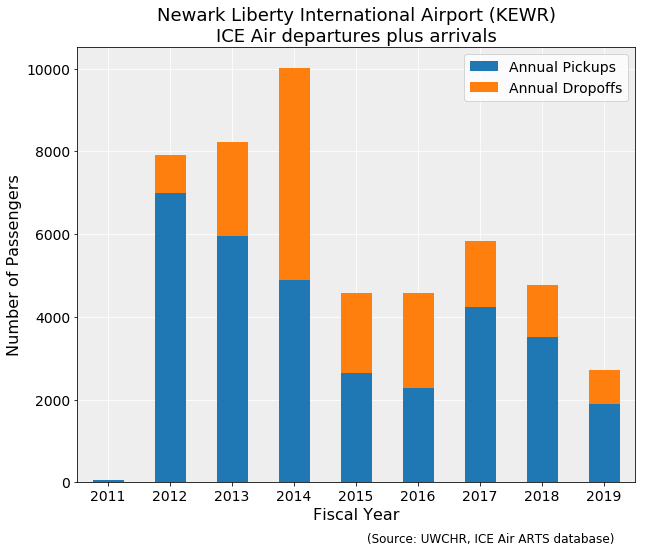

In [22]:
data = annual_summary[['Annual Pickups', 'Annual Dropoffs']]
title = f'{airport_name} ({airport})\nICE Air departures plus arrivals'
bar_chart(data, airport, airport_name, 'pickup-dropoff', title)
plt.show()

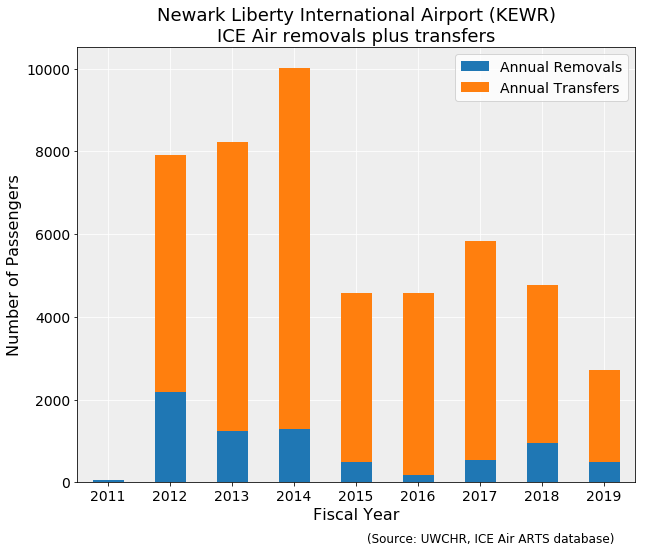

In [23]:
data = annual_summary[['Annual Removals', 'Annual Transfers']]
title = f'{airport_name} ({airport})\nICE Air removals plus transfers'
bar_chart(data, airport, airport_name, 'removal-transfer', title)
plt.show()

In [24]:
annual_summary[['Annual Pickups', 'Annual Dropoffs']].to_csv(f'../output/{airport}-AnnualDeparturesArrivals.csv')

In [25]:
all_df.to_csv(f'../output/{airport}-allpassengers.csv')

# Annual pickup rate, by criminal conviction status

WARNING: Criminal conviction data is not consistently recorded by ICE, especially in FY 11.

In [26]:
annual_non_criminal = pickup_df[['NonCriminal']].resample('AS-OCT').sum()

In [27]:
annual_non_criminal['total'] = annual_pickups
annual_non_criminal['percent'] = annual_non_criminal['NonCriminal']/annual_pickups*100

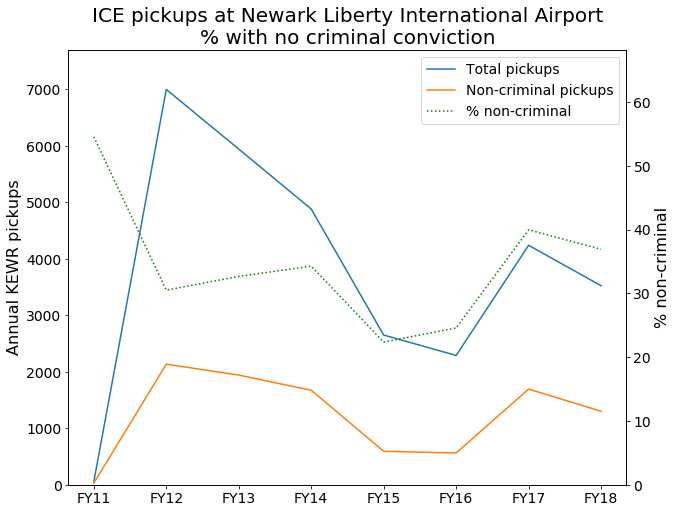

In [28]:
annual_data = annual_non_criminal['2010':'2017']
annual_data.index = [f'FY{str(x)[2:4]}' for x in range(2011,2019)]

# plt.style.use([{'legend.frameon': True}])
plt.rc("font", family="Sans-Serif")

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

lns1 = ax1.plot(annual_data['total'], label='Total pickups')
lns2 = ax1.plot(annual_data['NonCriminal'], label='Non-criminal pickups')
ax1_max = annual_data['total'].max()
ax1.set_ylim(0, (ax1_max * 1.1))
ax1.set_ylabel(f'Annual {airport} pickups', fontsize=16)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax2.grid(None)

lns3 = ax2.plot(annual_data['percent'], label='% non-criminal', linestyle=':', color='green')
ax2_max = annual_data['percent'].max()
ax2.set_ylim(0, (ax2_max * 1.25))
ax2.set_ylabel('% non-criminal', fontsize=16)
ax2.tick_params(axis='y', labelsize=14)
ax2.grid(None)
# ax2.set_xticklabels([f'FY{str(x)[2:4]}' for x in range(2011,2019)])

lns = [lns1[0], lns2[0], lns3[0]]
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0, fontsize=14)

ax1.set_title(f'ICE pickups at {airport_name}\n% with no criminal conviction', fontsize=20)

fig.set_size_inches(10, 8)

plt.show()
fig.savefig(f'../output/{airport}_NoCrim.png', dpi=100)

# Monthly averages (by FY)

Calculating average rates of pickups, dropoffs, and flights for each calendar year in the dataset.

In [30]:
monthly_means = pd.DataFrame()
for year in range(2011, 2019):
    mean_pickups = monthly_pickups[f'{year}'].mean()
    mean_pickup_missions = monthly_pickup_missions[f'{year}'].mean()
    mean_dropoffs = monthly_dropoffs[f'{year}'].mean()
    mean_dropoff_missions = monthly_dropoff_missions[f'{year}'].mean()
    monthly_means = monthly_means.append({'calendar_year':year,
                                          'monthly_mean_pickups':mean_pickups,
                                          'monthly_mean_dropoffs':mean_dropoffs,
                                          'monthly_mean_pickup_missions':mean_pickup_missions,
                                          'monthly_mean_dropoff_missions':mean_dropoff_missions,
                                         }, ignore_index=True)
monthly_means['calendar_year'] = monthly_means['calendar_year'].astype(int)
monthly_means = monthly_means.set_index('calendar_year')

In [31]:
monthly_means.round(2)

,monthly_mean_dropoff_missions,monthly_mean_dropoffs,monthly_mean_pickup_missions,monthly_mean_pickups
calendar_year,,,,
2011,34.67,34.67,328.25,328.25
2012,89.83,89.83,605.00,605.00
2013,248.08,248.08,475.25,475.25
2014,406.42,406.42,382.75,382.75
2015,159.25,159.25,189.00,189.00
2016,206.50,206.50,212.83,212.83
2017,81.25,81.25,353.25,353.25
2018,113.92,113.92,288.33,288.33


In [32]:
# monthly_means.to_csv(f'../output/{airport}_monthly_means.csv')

# Top nationalities

In [43]:
removal_df[removal_df['CountryOfCitizenship'] == 'EL SALVADOR']['DropLoc']

MissionDate
2014-10-27    MSLP
2014-10-27    MSLP
2014-10-27    MSLP
2014-10-27    MSLP
2014-10-27    MSLP
2014-10-27    MSLP
2014-10-27    MSLP
2014-10-27    MSLP
2014-10-27    MSLP
2014-10-27    MSLP
2014-10-27    MSLP
2014-10-27    MSLP
2014-10-27    MSLP
2014-10-27    MSLP
2014-10-27    MSLP
2014-10-27    MSLP
2014-10-27    MSLP
2014-10-27    MSLP
2014-10-27    MSLP
2014-10-27    MSLP
2014-10-27    MSLP
2014-10-27    MSLP
2014-10-27    MSLP
2014-10-27    MSLP
2014-10-27    MSLP
2014-10-27    MSLP
2014-10-27    MSLP
2014-10-27    MSLP
2014-10-27    MSLP
2014-10-27    MSLP
              ... 
2014-10-27    MSLP
2014-10-27    MSLP
2014-10-27    MSLP
2014-10-27    MSLP
2014-10-27    MSLP
2014-10-27    MSLP
2014-10-27    MSLP
2014-10-27    MSLP
2014-10-27    MSLP
2014-10-27    MSLP
2014-10-27    MSLP
2014-10-27    MSLP
2014-10-27    MSLP
2014-10-27    MSLP
2014-10-27    MSLP
2014-10-27    MSLP
2014-10-27    MSLP
2014-10-27    MSLP
2014-10-27    MSLP
2014-10-27    MSLP
2014-10-27    MSLP


In [ ]:
pickup_df.drop_duplicates(subset='AlienMasterID')['CountryOfCitizenship'].value_counts().head(10)

In [ ]:
dropoff_df.drop_duplicates(subset='AlienMasterID')['CountryOfCitizenship'].value_counts().head(5)

In [ ]:
all_df.drop_duplicates(subset='AlienMasterID')['CountryOfCitizenship'].value_counts().head(5)

In [ ]:
nat_percent = (df.groupby(['CountryOfCitizenship'])['AlienMasterID'].nunique() / len(df)).sort_values(ascending=False)

In [ ]:
airport_nat_percent = (all_df.groupby(['CountryOfCitizenship'])['AlienMasterID'].nunique() / len(all_df)).sort_values(ascending=False)

In [ ]:
pd.DataFrame({'Nationality as percent of dataset': nat_percent,
              f'Nationality as percent of {airport}': airport_nat_percent}).to_csv(f'../output/{airport}_nationality_percent_comparison.csv')

In [ ]:
removal_nationalities = removal_df.groupby([pd.Grouper(freq='AS-OCT'), 'CountryOfCitizenship'])['AlienMasterID'].nunique().unstack()
removal_nationalities.to_csv(f'../output/{airport}_removal_nationalities.csv')

# Chart of top nationalities per year

This chart shows the top five `CountryOfCitizenship` values for each fiscal year. It can be misleading because values are summed in "ALL OTHERS" for years in which a particular nationalitiy is not in the top 5, but it makes clear things like which years certain groups come into or leave the top 5.

Charts can be generated for pickups, dropoffs, removals, transfers, or all records.

In [ ]:
# Strangely, copying a DataFrame doesn't copy DataFrame.name
# There's probably a better way to link dataframes to downstream chart labels, though
df_to_analyze = pickup_df.copy()
df_to_analyze.name = pickup_df.name

In [ ]:
g = df_to_analyze.groupby([pd.Grouper(freq='AS-OCT', sort=True), 'CountryOfCitizenship'])['AlienMasterID', 'MissionID'].nunique()
country_of_citizenship_by_year = g.reset_index()
country_of_citizenship_by_year.rename({'MissionDate': 'FY'}, axis='columns', inplace=True)
country_of_citizenship_by_year.set_index('FY', inplace=True)
country_of_citizenship_by_year.sort_values(by='AlienMasterID', ascending=False, inplace=True)

# country_of_citizenship_by_year.to_csv(f'../output/{airport}_country_of_citizenship_by_year.csv', index=True)

In [ ]:
# Limiting to fiscal years with full data (FY2011-FY2018).
country_of_citizenship_by_year = country_of_citizenship_by_year['2010':'2017']

In [ ]:
all_passenger_nationality_by_year = country_of_citizenship_by_year.groupby([pd.Grouper(freq='AS-OCT'),'CountryOfCitizenship'])[['AlienMasterID']].sum().dropna(how='all',axis=0).unstack()
all_passenger_nationality_by_year.to_csv(f'../output/{airport}_all_passenger_nationality_by_year.csv')

In [ ]:
all_passenger_nationality_by_year.loc['2016':'2017'].T.dropna(how='all').to_csv('../output/kbfi_pickups_by_nationality.csv')

In [ ]:
top_5_df = pd.DataFrame()

for year in country_of_citizenship_by_year.index.unique():
    temp = country_of_citizenship_by_year.loc[f'{year}'][['CountryOfCitizenship', 'AlienMasterID']]
    temp_top_5 = temp[0:5]
    if len(temp) > 5:
        all_other_count = sum(temp['AlienMasterID'][5:])
    else:
        all_other_count = 0
    other_df = pd.DataFrame([['ALL OTHERS', all_other_count]], columns=['CountryOfCitizenship', 'AlienMasterID'], index=[year])
    temp_top_5 = temp_top_5.append(other_df)
    top_5_df = top_5_df.append(temp_top_5)
    
top_5_df.sort_index(inplace=True)
top_5_df.index = [f'FY{str(x)[2:4]}' for x in top_5_df.index.year + 1]

top_5_data = pd.pivot_table(data=top_5_df,
                       index=top_5_df.index,
                       columns='CountryOfCitizenship',
                       values='AlienMasterID',
                       aggfunc=np.sum,
                       fill_value=0)

top_5_data = top_5_data.reindex(top_5_data.sum().sort_values(ascending=False).index, axis=1)
cols = list(top_5_data.columns)
cols.remove('ALL OTHERS')
cols.append('ALL OTHERS')
top_5_data = top_5_data[cols]

top_5_data.columns = top_5_data.columns.str.title()
top_5_data.columns.name = 'Country of Citizenship'

In [ ]:
def country_of_citizenship_trend(data, title=str, filename=str, xlabel=str, ylabel=str):
    
    fig, ax = plt.subplots()
    
    data.plot(kind='bar', stacked=True, legend=True, ax=ax).legend(bbox_to_anchor=(1,1))

    ax.set_axisbelow(True)
    ax.set_facecolor('#EEEEEE')
    ax.grid(color='#FFFFFF')
    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_title(title, fontsize=18)
    ax.tick_params(labelsize=14)
    plt.xticks(rotation=0)
    txt='(Source: UWCHR, ICE Air ARTS database)'
    txt=plt.figtext(0.7, -0.00, txt, wrap=True, horizontalalignment='center', fontsize=12)
    lgd=plt.legend(fontsize=12)

    fig.set_size_inches(10, 8)
    fig.savefig(f'../output/{filename}.png', dpi=100, bbox_extra_artists=(lgd,txt), bbox_inches='tight')
    return fig, ax

In [ ]:
country_of_citizenship_trend(top_5_data,
                             title=f'{airport_name} \n ICE Air {df_to_analyze.name} by Country of Citizenship \n (Top 5 per year)',
                             filename=f'{airport}_top5_nationalities',
                             ylabel=f'Total {df_to_analyze.name}',
                             xlabel='Fiscal Year');

In [ ]:
g = pickup_df.groupby(['PULOC', pd.Grouper(freq='AS-OCT', sort=True), 'air2_AirportName'])['AlienMasterID','MissionID'].nunique()
drop_locs_by_year = g.reset_index()
drop_locs_by_year.rename({'MissionDate': 'FY'}, axis='columns', inplace=True)

# drop_locs_by_year.to_csv(f'../output/{airport}_drop_locs_by_year.csv', index=True)

# Alternate plot of top nationalities

Since selecting top 5 for each year is a bit counterintuitive, we can instead select here an aribtrary number of nationalities to display for all years, while summing others. This can be based on most common values or could be some other arbitrary list. (See also implementation in `global.ipynb` for plotting all values that break top 5 for any year.)

In [ ]:
annual = df_to_analyze.groupby([pd.Grouper(freq='AS-OCT', sort=True), 'CountryOfCitizenship'])['AlienMasterID'].nunique()

In [ ]:
# There is probably a better way to do this
annual = annual.reset_index()
annual.set_index('MissionDate', inplace=True)
annual = annual['2010':'2017']

In [ ]:
# Select arbitrary number of top values to display here
number_of_top_values = 5
annual_sum = annual.groupby(['CountryOfCitizenship'])['AlienMasterID'].sum()
top = list(annual_sum.sort_values(ascending=False).head(number_of_top_values).index)

top_df = pd.DataFrame()
top_df = top_df.append(annual[annual['CountryOfCitizenship'].isin(top)])
top_df.index = top_df.index.year

for year in annual.index.year.unique():
    temp = annual[f'{year}']
    temp2 = temp[~temp['CountryOfCitizenship'].isin(top)]
    all_other_count = temp2['AlienMasterID'].sum()
    other_df = pd.DataFrame([['ALL OTHERS', all_other_count]],
                            columns=['CountryOfCitizenship',
                                     'AlienMasterID'],
                            index=[year])
    top_df = top_df.append(other_df)

top_df.sort_index(inplace=True)
top_df.index = [f'FY{str(x)[2:4]}' for x in top_df.index + 1]

top_df['CountryOfCitizenship'] = top_df['CountryOfCitizenship'].astype('category')

top_data = pd.pivot_table(data=top_df,
                       index=top_df.index,
                       columns='CountryOfCitizenship',
                       values='AlienMasterID',
                       aggfunc=np.sum,
                       fill_value=0)
top_data = top_data.reindex(top_data.sum().sort_values(ascending=False).index, axis=1)
cols = list(top_data.columns)
cols.remove('ALL OTHERS')
cols.append('ALL OTHERS')
top_data = top_data[cols]
top_data.columns = top_data.columns.astype(str)
top_data.columns = top_data.columns.str.title()

In [ ]:
country_of_citizenship_trend(top_data,
                             title=f'ICE Air Departures from King County Int’l Airport (Boeing Field)\nby Country of Citizenship (Top 5 overall)',
                             filename=f'{airport}_pickup_nationalities',
                             ylabel=f'Total {df_to_analyze.name}',
                             xlabel='Fiscal Year');

# Not top nationalities

In [ ]:
number_of_top_values = 5
annual_sum = annual.groupby(['CountryOfCitizenship'])['AlienMasterID'].sum()
top = list(annual_sum.sort_values(ascending=False).head(number_of_top_values).index)

not_top_df = pd.DataFrame()
not_top_df = not_top_df.append(annual[~annual['CountryOfCitizenship'].isin(top)])
not_top_df.index = not_top_df.index.year

In [ ]:
not_top_data = pd.pivot_table(data=not_top_df,
                       index=not_top_df.index,
                       columns='CountryOfCitizenship',
                       values='AlienMasterID',
                       aggfunc=np.sum,
                       fill_value=0)
not_top_data = not_top_data.reindex(not_top_data.sum().sort_values(ascending=False).index, axis=1)
# cols = list(not_top_data.columns)
# cols.remove('ALL OTHERS')
# cols.append('ALL OTHERS')
# not_top_data = not_top_data[cols]
# not_top_data.columns = not_top_data.columns.astype(str)
# not_top_data.columns = not_top_data.columns.str.title()

In [ ]:
not_top_data.sum().head(15)

In [ ]:
all_others = not_top_data.sum()[not_top_data.sum() < 50].index
greater_than_x = not_top_data.sum()[not_top_data.sum() > 50].index
to_plot = not_top_data[greater_than_x].copy()
to_plot.columns = to_plot.columns.astype(str)
to_plot['ALL OTHERS'] = not_top_data[all_others].sum(axis=1)

In [ ]:
country_of_citizenship_trend(to_plot,
                             title=f'ICE Air Departures from {airport_name}\nby Country of Citizenship (Top 5 excluded)',
                             filename=f'{airport}_pickup_nationalities_top_5_excluded',
                             ylabel=f'Total {df_to_analyze.name}',
                             xlabel='Fiscal Year');

# Juveniles (by fiscal year)

Table of just juveniles for pickups, dropoffs. Currently will fail if no juveniles.

In [ ]:
assert sum(all_df['Juvenile']) > 0, f"No juveniles in dataset for {airport}"

In [ ]:
g = pickup_df.groupby(['PULOC', pd.Grouper(freq='AS-OCT', sort=True), 'Juvenile'])['AlienMasterID'].nunique()
juvenile_pickups = g.unstack()
juvenile_pickups['percent'] = juvenile_pickups[True] / juvenile_pickups[False] * 100
juvenile_pickups

In [ ]:
g = dropoff_df.groupby(['DropLoc', pd.Grouper(freq='AS-OCT', sort=True), 'Juvenile'])['AlienMasterID'].nunique()
juvenile_pickups = g.unstack()

In [ ]:
juvenile_pickups

In [ ]:
juvenile_pickups['percent'] = juvenile_pickups[True] / juvenile_pickups[False] * 100
juvenile_pickups

In [ ]:
g = all_df.groupby(['R-T', pd.Grouper(freq='AS-OCT', sort=True), 'Juvenile'])['AlienMasterID'].nunique()

In [ ]:
juvenile_removal_transfer = g.unstack()
juvenile_removal_transfer

# Detainee status

In [33]:
status_count = removal_df.drop_duplicates(subset='AlienMasterID')['Status'].str.upper().value_counts(dropna=False)

In [34]:
status = pd.read_csv('../../../share/resources/status.csv')

valid_status_codes = list(status['Code'])

status_dict = dict(zip(status['Code'], status['Status']))

pending = ['2A', '2B', '8A', '8B', '8D']
benefit = ['5C', '5D']
expedited_admin_rein = ['8F', '8G', '8H', '8I', '11', '16']
problematic = pending + benefit + expedited_admin_rein

In [40]:
problematic_count = 0
valid = removal_df['Status'].str.upper().isin(valid_status_codes)
valid_count = sum(valid)
invalid = ~removal_df['Status'].str.upper().isin(valid_status_codes)
invalid_count = sum(invalid)

print(f'{airport} - {airport_name}')
print()
print(f'ICE status codes for passengers on direct removal flights.')
print(f'(Statuses which may raise due process concerns starred)')
print()
print(f'{valid_count} valid values.')
print(f'{invalid_count} invalid values.')
print()
for c in valid_status_codes:
    
    try:
        count = status_count[c]
    except KeyError:
        count = 0
    
    if c in problematic:
        problematic_count = problematic_count + count
        print(f'[{c}]: *{count}* ({status_dict[c]})')
    else:
        print(f'[{c}]: {count} ({status_dict[c]})')
print()
print(f'{problematic_count} problematic cases.')
print(f"{sum(removal_df['Status'].isin(pending))} with pending appeals.")
print(f"{sum(removal_df['Status'].isin(benefit))} with benefit blocking deportation.")
print(f"{sum(removal_df['Status'].isin(expedited_admin_rein))} under expedited, administrative, reinstatement of removal.")

KEWR - Newark Liberty International Airport

ICE status codes for passengers on direct removal flights.
(Statuses which may raise due process concerns starred)

3363 valid values.
4079 invalid values.

[1A]: 0 (Voluntary Departure – Un-Expired and Un-Extended Voluntary Departure.)
[1B]: 0 (Voluntary Departure - Extended Departure Period)
[1C]: 0 (Exipred Voluntary Departure Period - Referred to Investigation)
[2A]: *4* (Deportable – Under Adjudication by IJ)
[2B]: *1* (Deportable – Under Adjudication by BIA)
[3]: 99 (Deportable – Administratively Final Order)
[5A]: 0 (Referred for Investigation - No Show for Hearing - No Final O...)
[5B]: 8 (Removable – ICE Fugitive)
[5C]: *0* (Relief Granted – Withholding of Deportation/Removal)
[5D]: *1* (Final Order of Deportation/Removal – Deferred Action Granted.)
[5E]: 0 (Relief Granted – Extended Voluntary Departure)
[5F]: 0 (Unable to Obtain Travel Document)
[8A]: *17* (Excludable/Inadmissible – Hearing Not Commenced)
[8B]: *86* (Excludable/Ina

In [36]:
sum(removal_df['Status'].isin(expedited_admin_rein))

1516

In [37]:
sum(removal_df['Status'].isin(pending))

120

In [38]:
sum(removal_df['Status'].isin(benefit))

1

In [ ]:
status_fy = removal_df.drop_duplicates(subset='AlienMasterID').resample('AS-OCT')['Status'].value_counts().unstack()
status_fy_valid = status_fy[status_fy.columns[status_fy.columns.isin(valid_status_codes)]]

total = removal_df.drop_duplicates(subset='AlienMasterID').resample('AS-OCT')['AlienMasterID'].nunique()

status_fy_valid.T.to_csv(f'../output/{airport}_valid_status_by_year.csv')

all_others = status_fy[status_fy.columns[~status_fy.columns.isin(valid_status_codes)]].sum(axis=1)
all_others.name = 'all_others'

status_table = pd.concat([status_fy_valid, all_others], axis=1).T

status_table.to_csv(f'../output/{airport}_removal_status_by_year.csv')
(status_table/total).to_csv(f'../output/{airport}_removal_status_by_year_percent.csv')

In [ ]:
total

In [ ]:
transfer_status = transfer_df['Status'].value_counts()

In [ ]:
transfer_status[transfer_status >= 100]

In [ ]:
pickup_transfer_status = pickup_df[pickup_df['R-T'] == 'T']['Status'].value_counts()

In [ ]:
pickup_transfer_status[pickup_transfer_status > 100]

In [ ]:
dropoff_status = dropoff_df['Status'].value_counts()
dropoff_status[dropoff_status > 1]

## Finding most common day of week

In [ ]:
all_df['MissionWeekday'] = all_df.index.weekday

In [ ]:
index = range(0,7)

In [ ]:
weekdays_2018 = all_df.loc['2018'].groupby(['MissionWeekday'])['MissionID'].nunique()

In [ ]:
weekdays_2018 = weekdays_2018.reset_index()

In [ ]:
weekdays_2018 = weekdays_2018.set_index('MissionWeekday')

In [ ]:
weekdays_2018 = weekdays_2018.reindex(index=index)

In [ ]:
weekdays_2018 = weekdays_2018.rename({'MissionID': 'Flights'}, axis=1)

In [ ]:
weekdays_2018 = weekdays_2018.T
weekdays_2018.columns = ['M', 'Tu', 'W', 'Th', 'F', 'Sa', 'Su']

In [ ]:
weekdays_2018.fillna(0, inplace=True)

In [ ]:
weekdays_2018

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(7,1)
ax = sns.heatmap(weekdays_2018, annot=True, annot_kws={"size": 20}, fmt='.0f', cmap=plt.cm.viridis, cbar=False)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16, rotation=0)
# ax.set_ylabel('Year', fontsize=14)
# ax.set_xlabel('Weekday', fontsize=14)
ax.set_title(f'Day of week of ICE Air flights at {airport_name} during 2018', fontsize=18, pad=10);
fig.savefig(f'../output/{airport}-weekdays.png', dpi=100,  bbox_inches='tight')

# Airport report

For a each airport ICAO code represented in the ICE Air data, output a uniform set of variables, tables, and figures.

In [86]:
airport_dict['KBFI']['AirportName']

'Boeing Field King County International Airport'

In [87]:
airport_dict['KBFI']

{'AirportName': 'Boeing Field King County International Airport',
 'City': 'Seattle',
 'Country': 'USA',
 'LatitudeDecimalDegrees': 47.53,
 'LongitudeDecimalDegrees': -122.302,
 'State': 'WA'}

In [88]:
def airport_report(airport_icao, print_report=False, figure=False):
    airport = airport_icao
    if airport.upper() in airport_dict.keys():
        pass
    else:
        print(f'{airport} not represented in dataset')
    airport_name = airport_dict[airport]['AirportName']
    pickup = df['PULOC'] == airport
    dropoff = df['DropLoc'] == airport

    pickup_df = df[pickup]
    dropoff_df = df[dropoff]

    first_pickup = pickup_df.MissionDate.min()
    last_pickup = pickup_df.MissionDate.max()
    first_dropoff = dropoff_df.MissionDate.min()
    last_dropoff = dropoff_df.MissionDate.max()

    pickup_df.set_index('MissionDate', inplace=True)
    dropoff_df.set_index('MissionDate', inplace=True)

    all_df = pd.concat([pickup_df, dropoff_df]).drop_duplicates()

    removal = all_df['R-T'] == 'R'
    transfer = all_df['R-T'] == 'T'
    removal_df = all_df[removal]
    transfer_df = all_df[transfer]

    all_df.name = 'Passengers'
    removal_df.name = 'Removals'
    transfer_df.name = 'Transfers'
    pickup_df.name = 'Pickups'
    dropoff_df.name = 'Dropoffs'

    # This grouped table would work for mapping flights from specific airports.
    all_missions = all_df.groupby(['MissionDate', 'MissionID', 'PULOC', 'DropLoc'])[['AlienMasterID']].nunique()
    
    monthly_pickups = pickup_df['AlienMasterID'].resample('M').nunique()
    monthly_dropoffs = dropoff_df['AlienMasterID'].resample('M').nunique()
    monthly_pickup_missions = pickup_df['MissionID'].resample('M').nunique()
    monthly_dropoff_missions = dropoff_df['MissionID'].resample('M').nunique()
    annual_pickups = pickup_df['AlienMasterID'].resample('AS-OCT').nunique()
    annual_dropoffs = dropoff_df['AlienMasterID'].resample('AS-OCT').nunique()
    annual_removals = removal_df['AlienMasterID'].resample('AS-OCT').nunique()
    annual_transfers = transfer_df['AlienMasterID'].resample('AS-OCT').nunique()
    annual_pickup_missions = pickup_df['MissionID'].resample('AS-OCT').nunique()
    annual_dropoff_missions = dropoff_df['MissionID'].resample('AS-OCT').nunique()
    annual_total = all_df['AlienMasterID'].resample('AS-OCT').nunique()
    
    unique_pickups = len(set(pickup_df['AlienMasterID']))
    unique_dropoffs = len(set(dropoff_df['AlienMasterID']))
    unique_removals = len(set(removal_df['AlienMasterID']))
    unique_transfers = len(set(transfer_df['AlienMasterID']))
    total_unique = len(set(all_df['AlienMasterID']))
    removal_percent = round(unique_removals / total_unique * 100, 2)
    transfer_percent = round(unique_transfers / total_unique * 100, 2)
    monthly_dropoff_avg = round(monthly_dropoffs.mean(), 2)
    monthly_pickup_avg = round(monthly_pickups.mean(), 2)
    monthly_dropoff_mission_avg = round(monthly_dropoff_missions.mean(), 2)
    monthly_pickup_mission_avg = round(monthly_pickup_missions.mean(), 2)
    unique_pickup_missions = len(set(pickup_df['MissionID']))
    unique_dropoff_missions = len(set(dropoff_df['MissionID']))
    total_missions = len(set(all_df['MissionID']))
    
    airport_vars = {airport:
                {'Airport Name': airport_name,
                 'City': airport_dict[airport]['City'],
                 'State': airport_dict[airport]['State'],
                 'Country': airport_dict[airport]['Country'],
                 'Latitude': airport_dict[airport]['LatitudeDecimalDegrees'],
                 'Longitude': airport_dict[airport]['LongitudeDecimalDegrees'],
                 'Total Pickups': unique_pickups,
                 'Total Dropoffs': unique_dropoffs,
                 'Total Removals': unique_removals,
                 'Total Transfers': unique_transfers,
                 'Total Passengers': total_unique,
                 'Removal Percent': removal_percent,
                 'Transfer Percent': transfer_percent,
#                  'Avg. Monthly Dropoffs': monthly_dropoff_avg,
#                  'Avg. Monthly Pickups': monthly_pickup_avg,
#                  'Avg. Monthly Dropoff Flights': monthly_dropoff_mission_avg,
#                  'Avg. Monthly Pickup Flights': monthly_pickup_mission_avg,
                 'Total Pickup Flights': unique_pickup_missions,
                 'Total Dropoff Flights': unique_dropoff_missions,
                 'Total Flights': total_missions}}
    
    row = pd.DataFrame(airport_vars).T
    
    fy_index = pd.date_range(start='2010-10-01', end='2018-01-01', freq='AS-OCT')
    annual_pickups.rename('Total pickups', inplace=True)
    annual_dropoffs.rename('Total dropoffs', inplace=True)
    annual_removals.rename('Total removals', inplace=True)
    annual_transfers.rename('Total transfers', inplace=True)
    annual_total.rename('Total passengers', inplace=True)
    annual_pickup_missions.rename('Total pickup missions', inplace=True)
    annual_dropoff_missions.rename('Total dropoff missions', inplace=True);
    annual_summary = pd.DataFrame({'Annual Removals': annual_removals,
                  'Annual Transfers': annual_transfers,
                  'Annual Pickups': annual_pickups,
                  'Annual Dropoffs': annual_dropoffs,
                  'Annual Pickup Missions': annual_pickup_missions,                                   
                  'Annual Dropoff Missions': annual_dropoff_missions,
                  'Annual Total': annual_total}, index=fy_index)

    annual_summary.index = annual_summary.index.year+1 
    annual_summary.index.name = 'Fiscal Year'
    flat_summary = annual_summary.unstack().to_frame().T 
    flat_summary.index = [airport]
    flat_summary.index.name = 'Airport Code'
    
# Uncomment if we want to include flattened FY figures alongside total vars
#     flat_summary.columns = flat_summary.columns.tolist()
#     row = row.join(flat_summary)
    
    if print_report == True:
        print(f'{airport} ({airport_name})')
        print(f'---------------------------------------------------------')
        print(f'{unique_pickups} passengers picked up, {unique_dropoffs} passengers dropped off.')
        print(f'{unique_removals} removals, {unique_transfers} transfers.')
        print(f"{total_unique} total unique passengers.")
        print(f"{removal_percent}% removals, {transfer_percent}% transfers")
        print(f'{monthly_dropoff_avg} average dropoffs per month.')
        print(f'{monthly_pickup_avg} average pickups per month.')
        print()
        print(f'{unique_pickup_missions} pickup missions, {unique_dropoff_missions} dropoff missions.')
        print(f"{all_df['MissionID'].nunique()} total missions.")
        print(f'{monthly_dropoff_mission_avg} average dropoff missions per month.')
        print(f'{monthly_pickup_mission_avg} average pickup missions per month.')
        print(f'First pickup mission: {first_pickup}; Last pickup flight: {last_pickup}')
        print(f'First dropoff mission: {first_dropoff}; Last dropoff mission: {last_dropoff}')
        print()
        print(monthly_dropoff_missions)

    if figure == True:
        fy_index = pd.date_range(start='2010-10-01', end='2018-01-01', freq='AS-OCT')
        annual_removals.rename('Total removals', inplace=True)
        annual_transfers.rename('Total transfers', inplace=True)
        annual_summary = pd.DataFrame({
              'Annual Removals': annual_removals,
              'Annual Transfers': annual_transfers}, index=fy_index)
        annual_summary.index = annual_summary.index.year+1 
        annual_summary.index.name = 'Fiscal Year'
        data = annual_summary[['Annual Removals', 'Annual Transfers']]
        bar_chart(data, airport, airport_name, '_R-T')

    return(row, flat_summary)

In [89]:
airport_total_df = pd.DataFrame()
airport_fy_df = pd.DataFrame()
for key in airport_dict.keys():
    try:
        total, fy = airport_report(key)
    except AttributeError:
        pass
    airport_total_df = airport_total_df.append(total)
    airport_fy_df = airport_fy_df.append(fy)

In [90]:
airport_metadata = airport_total_df[['Airport Name',
'City',
'State',
'Country',
'Latitude',
'Longitude']]

In [91]:
airport_metadata.columns = pd.MultiIndex.from_arrays([['Airport Location'] * len(airport_metadata.columns), airport_metadata.columns])

In [92]:
[airport_metadata.columns, ['Airport Location'] * len(airport_metadata.columns)]

[MultiIndex(levels=[['Airport Location'], ['Airport Name', 'City', 'Country', 'Latitude', 'Longitude', 'State']],
            labels=[[0, 0, 0, 0, 0, 0], [0, 1, 5, 2, 3, 4]]),
 ['Airport Location',
  'Airport Location',
  'Airport Location',
  'Airport Location',
  'Airport Location',
  'Airport Location']]

In [93]:
airport_fy_df = airport_metadata.join(airport_fy_df)

In [94]:
airport_fy_df.index.name = 'Airport Code'

In [95]:
airport_fy_df.head()

Airport Location                                   \
                                Airport Name         City State       Country   
Airport Code                                                                    
BKPR          Pristina International Airport     Pristina   NaN        Kosovo   
DAAG               Houari Boumediene Airport      Algiers   NaN       Algeria   
DFFD                     Ouagadougou Airport  Ouagadougou   NaN  Burkina Faso   
DGAA            Kotoka International Airport        Accra   NaN         Ghana   
DIAP                      Port Bouet Airport      Abidjan   NaN   Ivory Coast   

                                Annual Removals                  ...    \
             Latitude Longitude            2011  2012 2013 2014  ...     
Airport Code                                                     ...     
BKPR          42.5728   21.0358             2.0   0.0  0.0  0.0  ...     
DAAG           36.691     3.215             NaN   NaN  NaN  NaN  ...     
DFFD           12.353    -1.512             NaN   NaN  NaN  NaN  ...     
DGAA            5.603    -0.168            17.0  14.0  0.0  0.0  ...     
DIAP             5.26    -3.926            11.0   0.0  0.0  0.0  ...     

             Annual Dropoff Missions      Annual Total                       \
                                2017 2018         2011  2012 2013 2014 2015   
Airport Code                                                                  
BKPR                             NaN  NaN          2.0   0.0  0.0  0.0  0.0   
DAAG                             1.0  NaN          NaN   NaN  NaN  NaN  NaN   
DFFD                             NaN  1.0          NaN   NaN  NaN  NaN  NaN   
DGAA                             3.0  2.0         17.0  14.0  0.0  0.0  0.0   
DIAP                             0.0  3.0         11.0   0.0  0.0  0.0  0.0   

                                  
              2016   2017   2018  
Airport Code                      
BKPR           2.0    NaN    NaN  
DAAG           NaN    3.0    NaN  
DFFD           NaN    NaN    5.0  
DGAA          17.0  172.0  130.0  
DIAP           5.0    0.0   13.0  

[5 rows x 62 columns]

In [96]:
airport_total_df.to_csv('../output/airport_totals.csv')
airport_fy_df.to_csv('../output/airport_fy.csv')
airport_fy_df.to_excel('../output/airport_fy.xlsx')

In [97]:
# Run this cell if you want to output tons of graphics.
# for key in airport_dict.keys():
#     try:
#         airport_report(airport_icao=key, figure=True)
#     except AttributeError:
#         pass